In [0]:
import json
import csv
import numpy as np
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd


In [2]:
pip install python-igraph

     |████████████████████████████████| 3.2MB 3.5MB/s 


In [0]:
import igraph

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/ECE 232e/Project4')

In [0]:
with open('los_angeles_censustracts.json') as json_data:
    location_data = json.load(json_data)

location_data=location_data['features']
location_dictionary = {}


for entry in location_data:
    
    movement_id = entry['properties']['MOVEMENT_ID']
    coord_list = np.array(entry['geometry']['coordinates'][0][0])
    if np.array(coord_list.shape).shape[0] > 1:
      mean_coord = np.mean(coord_list,axis=0)
      longitude =mean_coord[0]
      latitude = mean_coord[1]
    else:
      longitude = coord_list[0]
      latitude = coord_list[1]
    #print(mean_coord)
    #print(np.array(coord_list.shape).shape[0])
    location_dictionary[movement_id] = [longitude,latitude]


# **export to R**

In [0]:
a = list(location_dictionary.values())
node_info = pd.DataFrame(data = location_dictionary.keys(),columns = ['id'])
node_a = pd.DataFrame(data = a,columns=['long','latt'])
result = pd.concat([node_info, node_a], axis=1)
result.to_csv('nodeinfo.csv',index=True)

In [0]:
graph_data = pd.read_csv('los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
graph_data = graph_data.drop(['standard_deviation_travel_time', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'], axis=1)
graph_data = graph_data.drop(graph_data[graph_data.month != 12].index)
dec_data = graph_data.drop(['month'], axis=1)
dec_data.to_csv('decdata.csv',index=True)

In [0]:
uber_gcc = np.loadtxt('uber_gcc.txt')
uber_gcc_graph = {}
for row in uber_gcc:
    location_index = tuple(np.sort(row[0:2]).astype('int')) #nodes
    uber_gcc_graph[location_index] = row[2] #weights


In [0]:
uber_gcc_ids = np.concatenate([uber_gcc[:,0],uber_gcc[:,1]]).astype(int)
uber_gcc_ids = np.unique(uber_gcc_ids).astype('int')

mean_coords = np.zeros((len(uber_gcc_ids),2))
for n,location_key in enumerate(uber_gcc_ids):
    mean_coords[n,:] = location_dictionary[str(location_key)]

# **TRI**

In [0]:
malibu=[-118.56,   34.04]

longbeach = [-118.18,   33.77]


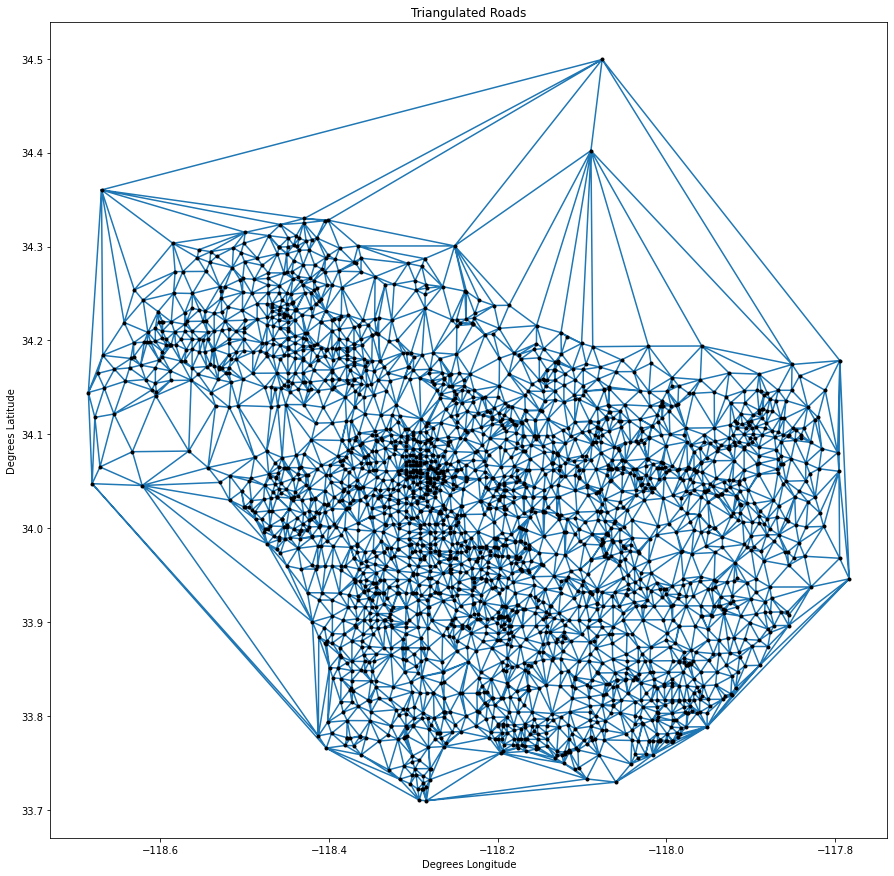

In [12]:
tri = Delaunay(mean_coords)

plt.figure(figsize=(15,15))
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'k.')

plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads')
plt.show()

In [0]:

malibutri =  tri.simplices[tri.find_simplex([-118.56,34.04])]

distance_miles1={}
for p2 in malibutri:
    coord1 = np.array([-118.56,34.04])
    coord2 = location_dictionary[str(p2)]
    distance_miles1[p2] =  np.linalg.norm(coord1-coord2)



longbeachtri =  tri.simplices[tri.find_simplex([-118.18,33.77])]
distance_miles2={}
for p2 in longbeachtri:
    coord1 = np.array([-118.18,33.77])
    coord2 = location_dictionary[str(p2)]
    distance_miles2[p2] =  np.linalg.norm(coord1-coord2)

In [14]:
malibutri 
distance_miles1
location_dictionary['1712']

[-118.621454, 34.045593]

# **FLOW**

In [0]:
def calc_flow(p1, p2):
    coord1 = np.array(location_dictionary[str(p1)])
    coord2 = np.array(location_dictionary[str(p2)])
    distance_miles = 69 * np.linalg.norm(coord1-coord2)
    if (p1,p2) in uber_gcc_graph.keys():
        travel_time = uber_gcc_graph[(p1,p2)] / 3600
        speed = distance_miles / travel_time
        time = 0.003/speed + 1/1800
        flow = 2/time
        return [flow, uber_gcc_graph[(p1,p2)]]
    else:
        return [0,0]

In [0]:

triangulated_graph = {}

for triangle_idx in tri.simplices:

    edge12 = tuple(np.sort([uber_gcc_ids[triangle_idx[0]],uber_gcc_ids[triangle_idx[1]]]))
    edge13 = tuple(np.sort([uber_gcc_ids[triangle_idx[0]],uber_gcc_ids[triangle_idx[2]]]))
    edge23 = tuple(np.sort([uber_gcc_ids[triangle_idx[1]],uber_gcc_ids[triangle_idx[2]]]))   

    flow12 = calc_flow(edge12[0],edge12[1])
    flow13 = calc_flow(edge13[0],edge13[1])
    flow23 = calc_flow(edge23[0],edge23[1])

    if edge12 not in triangulated_graph.keys():
        triangulated_graph[edge12] = flow12[0]
    if edge13 not in triangulated_graph.keys():
        triangulated_graph[edge13] = flow13[0]
    if edge23 not in triangulated_graph.keys():
        triangulated_graph[edge23] = flow23[0]



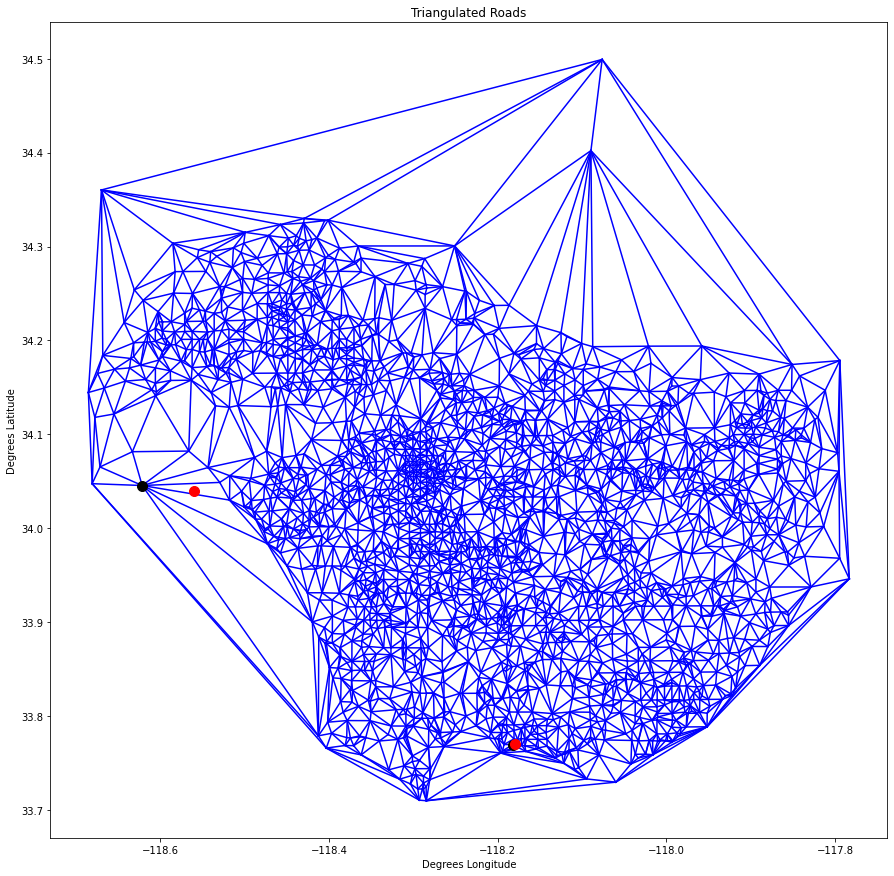

In [17]:
plt.figure(figsize=(15,15))

for location_key in triangulated_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

node1 = location_dictionary['1712']
plt.plot(node1[0],node1[1],'k.',ms=20)
node2 = location_dictionary['666']
plt.plot(node2[0],node2[1],'k.',ms=20)

plt.plot(malibu[0],malibu[1],'r.',ms=20)
plt.plot(longbeach[0],longbeach[1],'r.',ms=20)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads')
plt.show()

# **Enlarged Node**

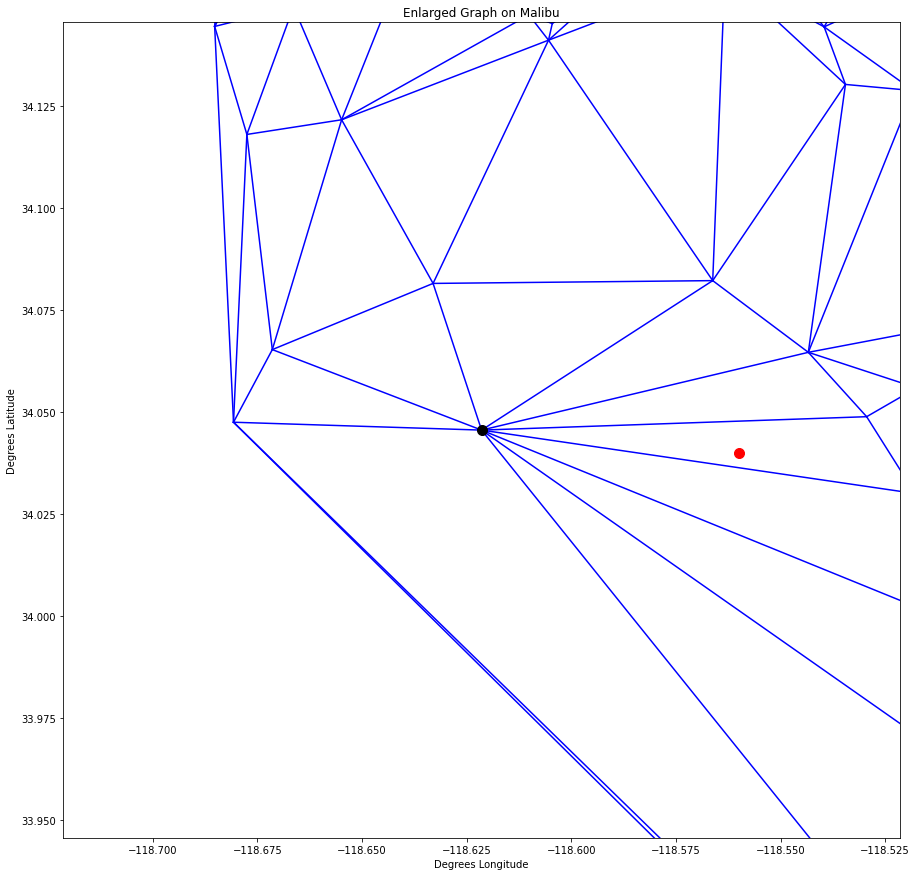

In [18]:
plt.figure(figsize=(15,15))

for location_key in triangulated_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

node = location_dictionary['1712']
plt.plot(node[0],node[1],'k.',ms=20)
plt.plot(malibu[0],malibu[1],'r.',ms=20)

plt.xlim((node[0]-0.1,node[0]+0.1))
plt.ylim((node[1]-0.1,node[1]+0.1))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Enlarged Graph on Malibu')
plt.show()

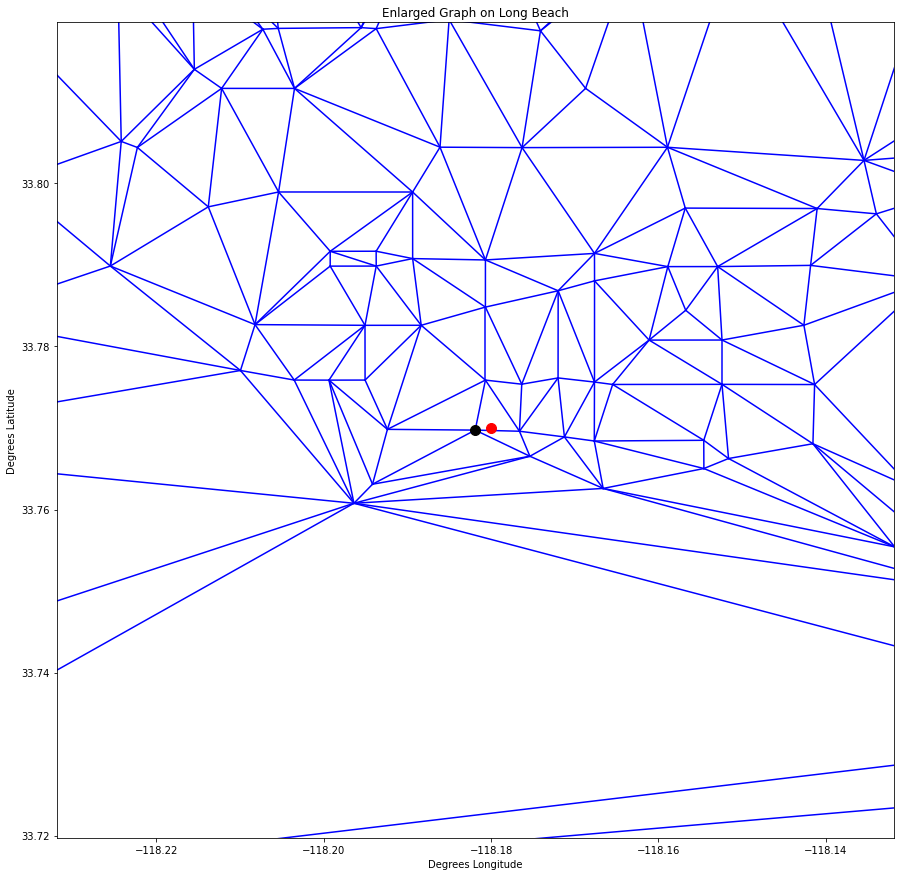

In [19]:
plt.figure(figsize=(15,15))

for location_key in triangulated_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

node = location_dictionary['666']
plt.plot(node[0],node[1],'k.',ms=20)

plt.plot(longbeach[0],longbeach[1],'r.',ms=20)
plt.xlim((node[0]-0.05,node[0]+0.05))
plt.ylim((node[1]-0.05,node[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Enlarged Graph on Long Beach')
plt.show()

In [0]:
with open('triangulated_graph.txt','w') as f:
    for locations in triangulated_graph:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),triangulated_graph[locations])
        f.write(string)

# **Pruned**

In [0]:
pruned_triangulated_graph = {}
tresh = 60*10

for triangle_idx in tri.simplices:

    edge12 = tuple(np.sort([uber_gcc_ids[triangle_idx[0]],uber_gcc_ids[triangle_idx[1]]]))
    edge13 = tuple(np.sort([uber_gcc_ids[triangle_idx[0]],uber_gcc_ids[triangle_idx[2]]]))
    edge23 = tuple(np.sort([uber_gcc_ids[triangle_idx[1]],uber_gcc_ids[triangle_idx[2]]]))   

    flow12 = calc_flow(edge12[0],edge12[1])
    flow13 = calc_flow(edge13[0],edge13[1])
    flow23 = calc_flow(edge23[0],edge23[1])

    if edge12 not in pruned_triangulated_graph.keys() and flow12[0] > 0 and flow12[1] < tresh:
        pruned_triangulated_graph[edge12] = flow12[0]
    if edge13 not in pruned_triangulated_graph.keys() and flow13[0] > 0 and flow13[1] < tresh:
        pruned_triangulated_graph[edge13] = flow13[0]
    if edge23 not in pruned_triangulated_graph.keys() and flow23[0] > 0 and flow23[1] < tresh:
        pruned_triangulated_graph[edge23] = flow23[0]


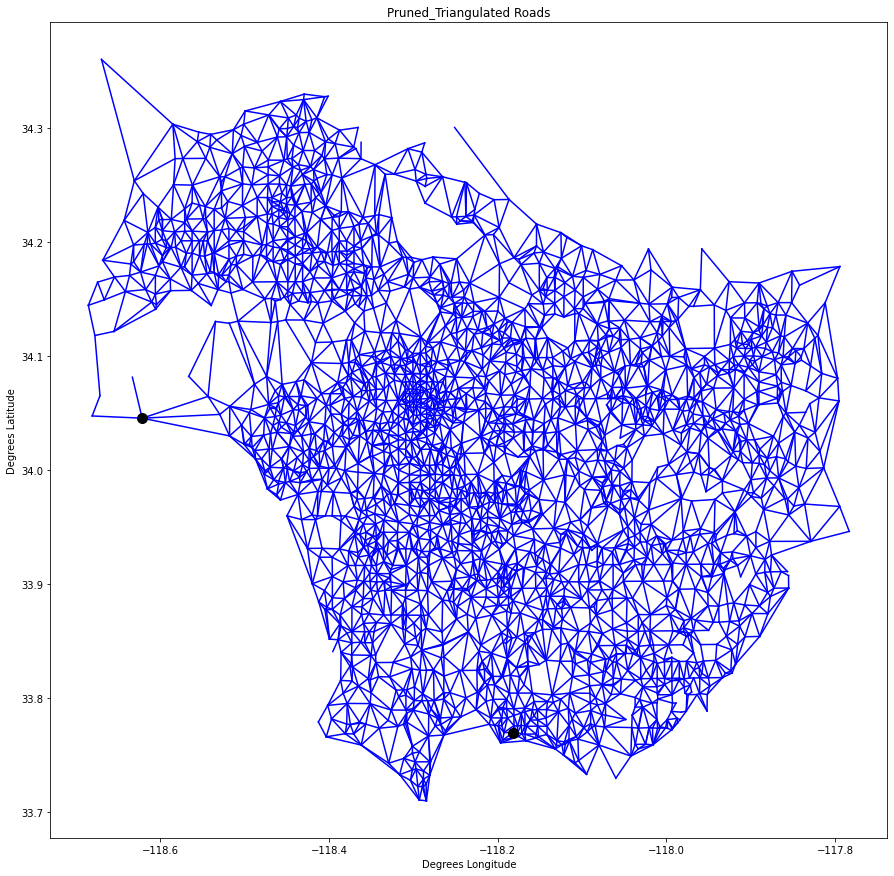

In [22]:
plt.figure(figsize=(15,15))

for location_key in pruned_triangulated_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

node1 = location_dictionary['1712']
plt.plot(node1[0],node1[1],'k.',ms=20)
node2 = location_dictionary['666']
plt.plot(node2[0],node2[1],'k.',ms=20)

plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned_Triangulated Roads')
plt.show()

# **Enlarged**

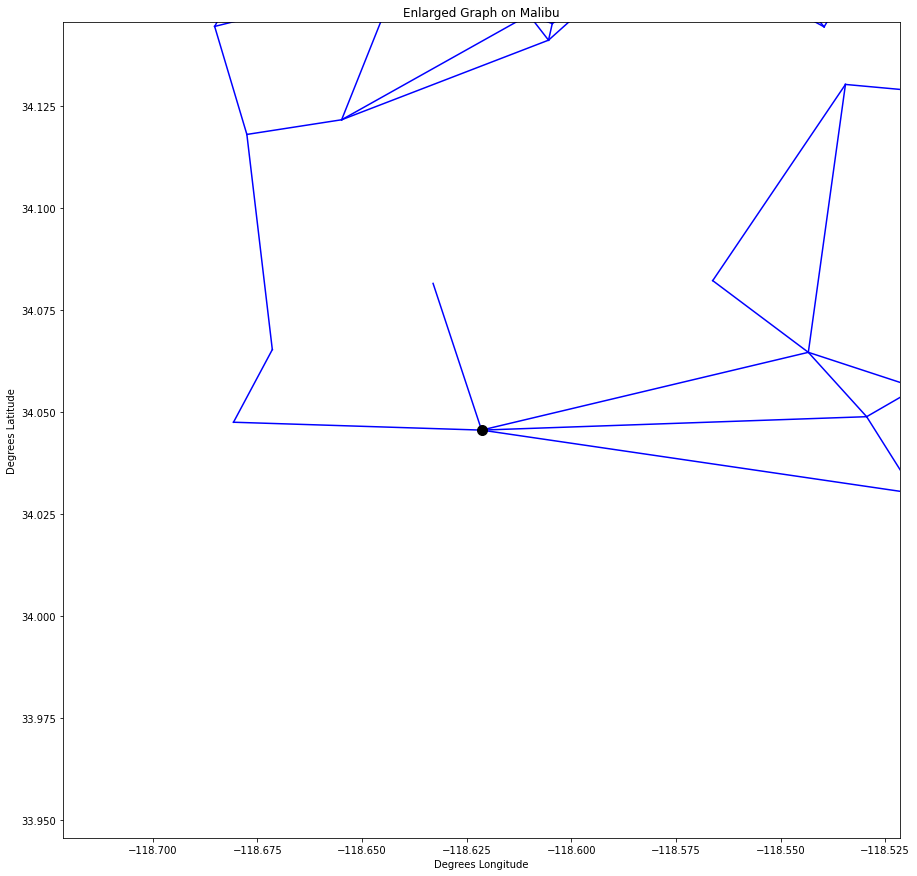

In [23]:
plt.figure(figsize=(15,15))

for location_key in pruned_triangulated_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

node = location_dictionary['1712']
plt.plot(node[0],node[1],'k.',ms=20)

plt.xlim((node[0]-0.1,node[0]+0.1))
plt.ylim((node[1]-0.1,node[1]+0.1))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Enlarged Graph on Malibu')
plt.show()

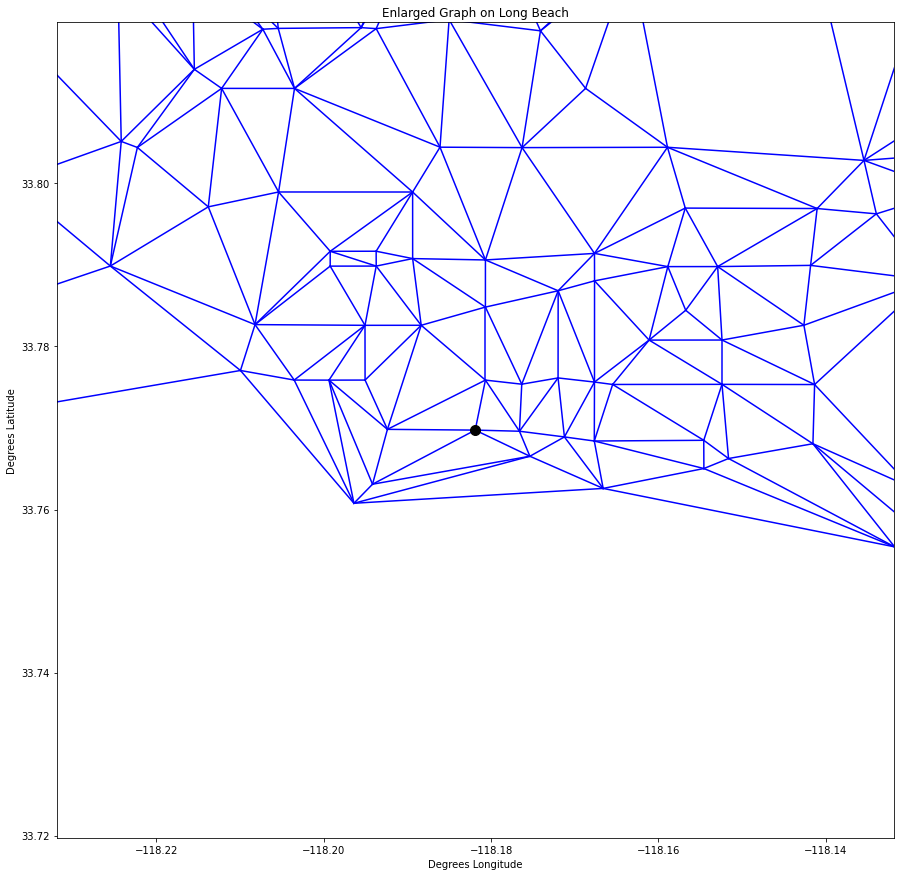

In [24]:
plt.figure(figsize=(15,15))

for location_key in pruned_triangulated_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

node = location_dictionary['666']
plt.plot(node[0],node[1],'k.',ms=20)

plt.xlim((node[0]-0.05,node[0]+0.05))
plt.ylim((node[1]-0.05,node[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Enlarged Graph on Long Beach')
plt.show()

In [0]:
with open('pruned_triangulated_graph.txt','w') as f:
    for locations in pruned_triangulated_graph:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]), pruned_triangulated_graph[locations])
        f.write(string)

# **Own task**

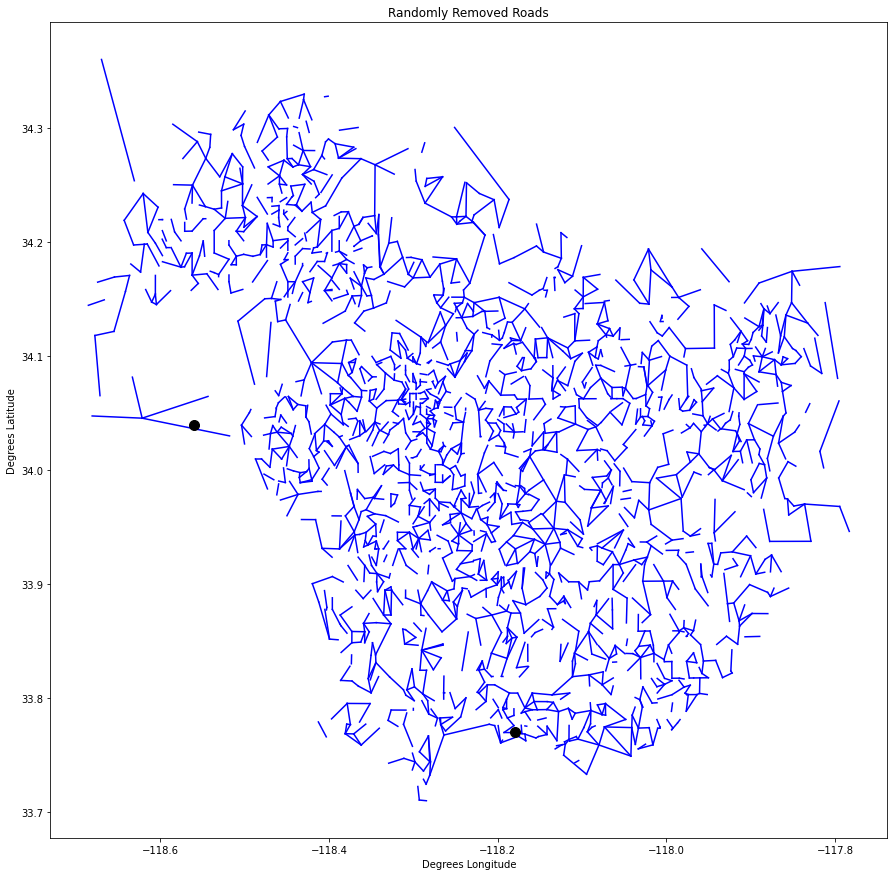

In [26]:
rand_gcc = np.loadtxt('sparse_rand_70.txt')
rand_gcc_graph = {}
for row in rand_gcc:
    location_index = tuple(np.sort(row[0:2]).astype('int')) #nodes
    rand_gcc_graph[location_index] = row[2] #weights

plt.figure(figsize=(15,15))

for location_key in rand_gcc_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

plt.plot(longbeach[0],longbeach[1],'k.',ms=20)
plt.plot(malibu[0],malibu[1],'k.',ms=20)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Randomly Removed Roads')
plt.show()

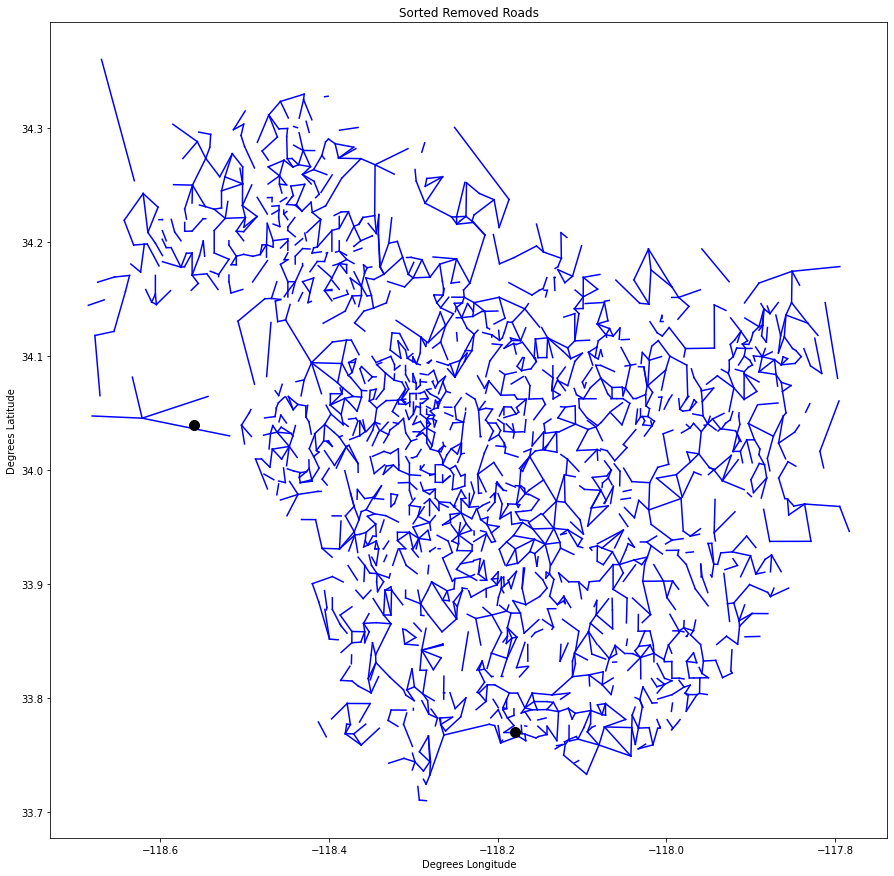

In [27]:
sort_gcc = np.loadtxt('sparse_sort_5.txt')
sort_gcc_graph = {}
for row in rand_gcc:
    location_index = tuple(np.sort(row[0:2]).astype('int')) #nodes
    sort_gcc_graph[location_index] = row[2] #weights

plt.figure(figsize=(15,15))

for location_key in sort_gcc_graph.keys():
    from_coords = location_dictionary[str(location_key[0])]
    to_coords = location_dictionary[str(location_key[1])]
    plt.plot([from_coords[0],to_coords[0]],[from_coords[1],to_coords[1]],color='b')

plt.plot(longbeach[0],longbeach[1],'k.',ms=20)
plt.plot(malibu[0],malibu[1],'k.',ms=20)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Sorted Removed Roads')
plt.show()

# Mean Stat

In [28]:
sparse_data = pd.read_csv('sparse_mean.csv')
sparse_data

,Percent,meanpath1,meanflow1,meanpath2,meanflow2
0,0.01,3.90,11655.2815,4,12073.25
1,0.02,3.86,11479.0673,3,8763.39
2,0.03,3.77,11163.7839,2,5499.79
3,0.04,3.73,10962.6783,1,3215.75
4,0.05,3.70,10839.5348,0,0.00
5,0.10,3.16,9313.7974,0,0.00
6,0.15,2.90,8415.4834,0,0.00
7,0.20,2.61,7365.3914,0,0.00
8,0.25,2.23,6278.5579,0,0.00
9,0.30,2.14,6003.2283,0,0.00


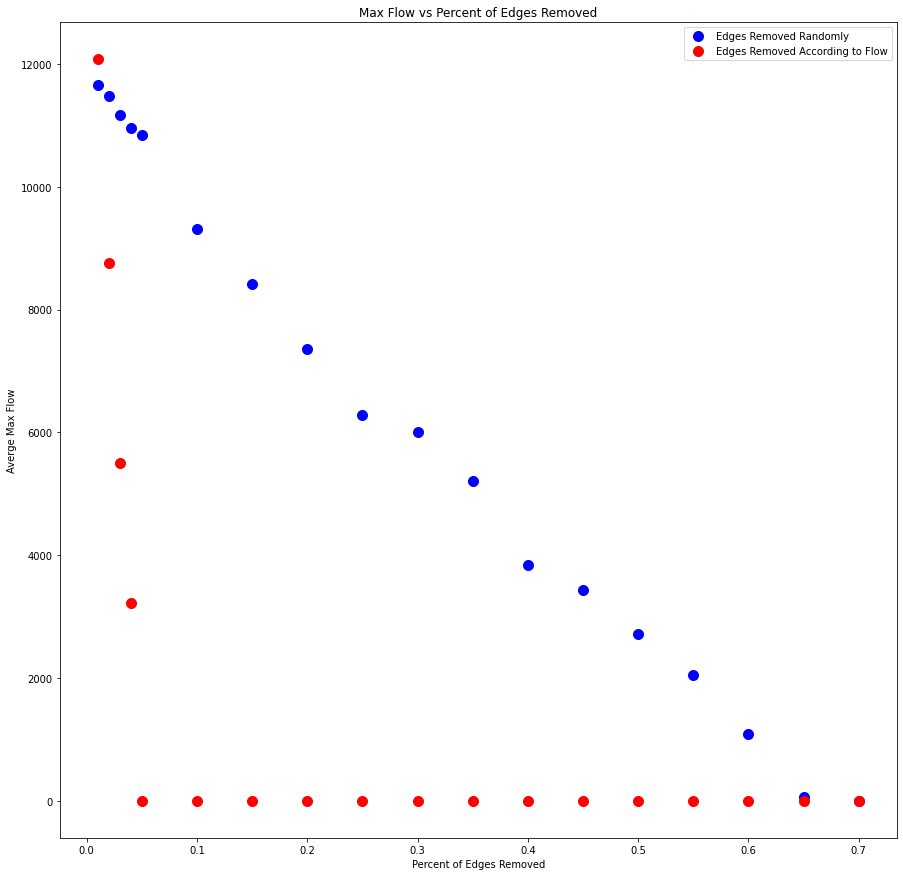

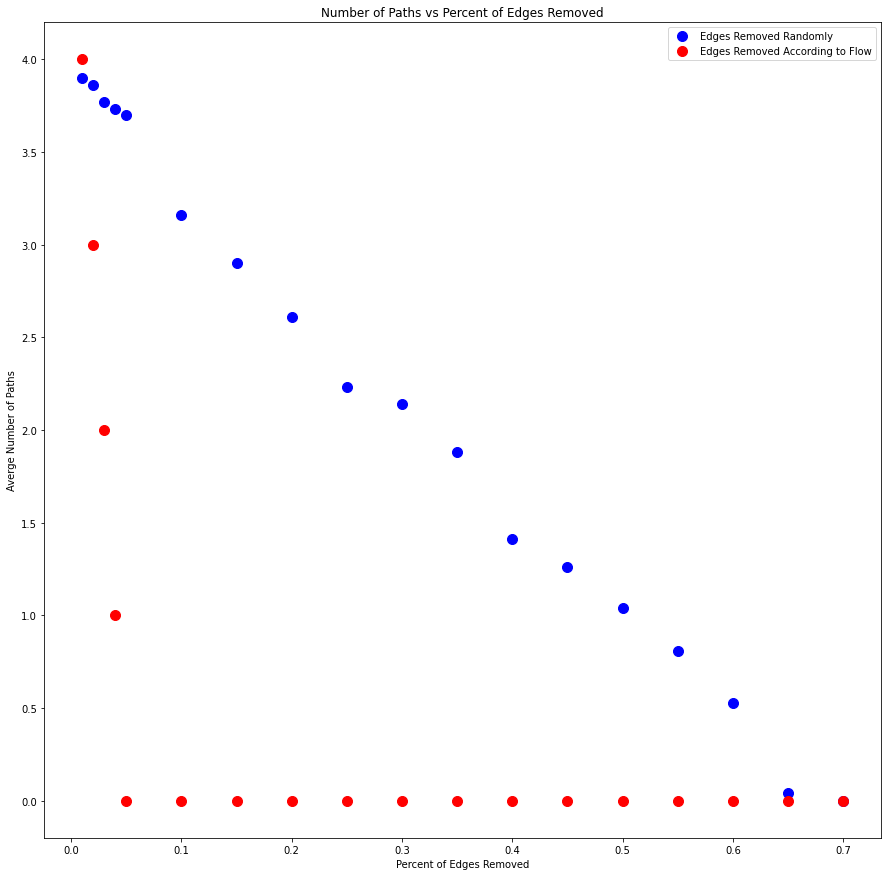

In [29]:





handel = ['Edges Removed Randomly', 'Edges Removed According to Flow']
plt.figure(figsize=(15,15))
plt.plot(sparse_data['Percent'],sparse_data['meanflow1'],'b.',ms=20)
plt.plot(sparse_data['Percent'],sparse_data['meanflow2'],'r.',ms=20)
plt.xlabel('Percent of Edges Removed')
plt.ylabel('Averge Max Flow')
plt.title('Max Flow vs Percent of Edges Removed')
plt.legend(handel)
plt.show()

plt.figure(figsize=(15,15))
plt.plot(sparse_data['Percent'],sparse_data['meanpath1'],'b.',ms=20)
plt.plot(sparse_data['Percent'],sparse_data['meanpath2'],'r.',ms=20)
plt.xlabel('Percent of Edges Removed')
plt.ylabel('Averge Number of Paths')
plt.title('Number of Paths vs Percent of Edges Removed')
plt.legend(handel)
plt.show()

